In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

%matplotlib inline

def run_query(q):
    with sq.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sq.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    liste_tables=run_query("SELECT name,type FROM sqlite_master WHERE type IN ('table','view');")
    return(liste_tables)
      

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [35]:
c1='CREATE VIEW all_tracks_genre AS SELECT t.*, g.name genre, SUM(il.quantity) quantity, i.billing_country country  FROM track t INNER JOIN genre g ON t.genre_id=g.genre_id INNER JOIN invoice_line il ON t.track_id=il.track_id INNER JOIN invoice i ON il.invoice_id=i.invoice_id WHERE country="USA" GROUP BY (t.track_id);'
run_command(c1)


## Rechercher les genres les plus vendus aux USA

In [14]:
q2='SELECT a.genre, SUM(a.quantity) total_quantity, (CAST(SUM(a.quantity) as FLOAT)/(SELECT CAST(SUM(quantity) as FLOAT) FROM all_tracks_genre))*100 percentage FROM all_tracks_genre a GROUP BY a.genre ORDER BY percentage DESC;'
top_genre_usa=run_query(q2)
top_genre_usa

,genre,total_quantity,percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


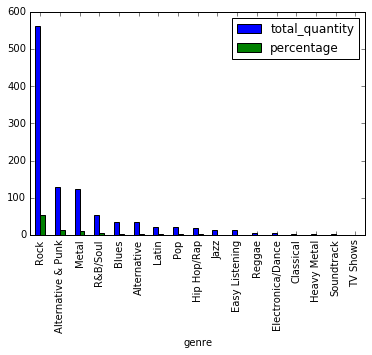

In [15]:
top_genre_usa.set_index('genre', drop=True, inplace=True)
top_genre_usa.plot.bar()
plt.show()

L'ordre est clairement présenté sur la ficgure et dans le tableau "top_genre_usa"

L'entreprise devrait donc privilégier Red Tone, Slim Jim Bites et Meteor and the Girls.
Le hip hop n'est pas classé dans le top 3 des ventes de ce magasin aux USA

## Rechercher les Sales Support Agent avec les meilleures ventes

1- Créer la vue 'depenses_par_cons' qui montre toutes les dépenses par consommateur avec les informations de leur Sales Support agent

In [56]:
c3="CREATE VIEW depenses_par_cons AS SELECT c.customer_id,(c.first_name||' '||c.last_name) customer_name, c.country	customer_country, c.support_rep_id employe_support, i.billing_country, SUM(i.total) depenses_total, (e.first_name||' '||e.last_name) employe_name, e.title, e.hire_date, e.country employe_country FROM customer c INNER JOIN invoice i ON c.customer_id=i.customer_id INNER JOIN employee e ON c.support_rep_id=e.employee_id GROUP BY c.customer_id;"
run_command(c3)

2- Sommer les dépenses de tous les consommateurs en les groupant par Sales Suport Agent

In [6]:
q3="SELECT employe_name, employe_country, title, hire_date, SUM(depenses_total) ventes FROM depenses_par_cons GROUP BY employe_name ORDER BY ventes DESC;"
top_ventes_employe=run_query(q3)
top_ventes_employe

,employe_name,employe_country,title,hire_date,ventes
0,Jane Peacock,Canada,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Canada,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Canada,Sales Support Agent,2017-10-17 00:00:00,1393.92


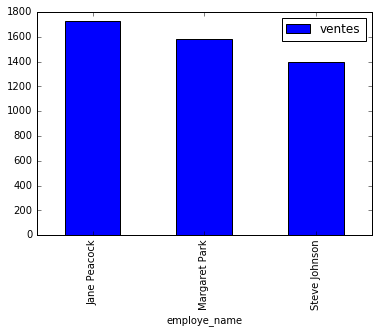

In [7]:
top_ventes_employe.set_index('employe_name', drop=True, inplace=True)
top_ventes_employe.plot.bar()
plt.show()

Je n'ai pas constaté de réel gap entre les vendeurs. La date d'embauche peut expliquer la variation, on peut produire un scatter plot pour observer s'il y a une corrélation entre la date d'embauche et le montant des ventes => mais on a que 3 valeurs et les scatter plot ne prennent que des valeurs numériques (la date d'embauche est du date time)...

In [23]:
c3='''DROP VIEW donnees_vente_pays;'''
run_command(c3)
#c3="select * from donnees_vente_pays;"
#run_query(c3)

## Analyser les données de ventes de chaque pays

In [24]:
#Cette requête ramène le nombre total de consommateurs par pays, le total des ventes par pays
# le montant moyen de vente par consommateurs par pays et le montant moyen d'une commande par pays

c4='''
    CREATE VIEW donnees_vente_pays AS
                        WITH montant_moyen_commande_cons AS
                          (SELECT 
                                 c.customer_id,
                                 CASE
                                  WHEN (SELECT count(*)
                                  FROM customer
                                  WHERE country = c.country) = 1 
                                  THEN "Other"
                                  ELSE c.country
                                  END AS customer_country,
                                 SUM(i.total)/COUNT(i.invoice_id) commande_moyenne       
                           FROM customer c 
                           INNER JOIN invoice i ON c.customer_id=i.customer_id 
                           GROUP BY c.customer_id)
                           
                        SELECT m.customer_country,
                               COUNT(m.customer_country) customer_nbr, 
                               SUM(d.depenses_total) total_vente,
                               SUM(d.depenses_total)/COUNT(d.customer_id) moyenne_vente_par_cons,
                               SUM(m.commande_moyenne)/COUNT(m.commande_moyenne) commande_moyenne_par_pays
                         FROM depenses_par_cons d 
                         INNER JOIN montant_moyen_commande_cons m ON d.customer_id=m.customer_id
                         GROUP BY m.customer_country;'''

run_command(c4)

In [6]:
#Table récapitulative sortant les données par ordre décroissant du nombre total des ventes 
#en forçant les pays ayant un seul consommateur en bas de liste
q4='SELECT * FROM donnees_vente_pays;'

q5='''
SELECT
    customer_country,
    CASE WHEN customer_nbr=1
         THEN (SELECT COUNT(*) FROM donnees_vente_pays WHERE customer_country="Other")
         ELSE customer_nbr
         END AS customer_nbr,
    total_vente,
    commande_moyenne_par_pays,
    moyenne_vente_par_cons
FROM
    (
    SELECT
        dv.*,
        CASE
            WHEN dv.customer_country = "Other" THEN 1
            ELSE 0
        END AS autres
    FROM donnees_vente_pays dv
    ORDER BY dv.total_vente DESC
   )
GROUP BY (customer_country)
ORDER BY autres ASC, total_vente DESC
'''
donnees_vente_pays=run_query(q5)
donnees_vente_pays

,customer_country,customer_nbr,total_vente,commande_moyenne_par_pays,moyenne_vente_par_cons
0,USA,13,1040.49,8.014750,80.037692
1,Canada,8,535.59,7.416238,66.948750
2,Brazil,5,427.68,6.987485,85.536000
3,France,5,389.07,7.835000,77.814000
4,Germany,4,334.62,8.188750,83.655000
5,Czech Republic,2,273.24,9.377500,136.620000
6,United Kingdom,3,245.52,8.749583,81.840000
7,Portugal,2,185.13,6.527813,92.565000
8,India,2,183.15,8.757692,91.575000
9,Other,15,1094.94,7.445071,72.996000


Je constate un petit biais dans la valeur moyenne d'une pays par pays, mais je crois que cela est dû à l'arrondi, moi j'ai calculé avec la somme totale
et le gars du correctif l'a fait avec les sommes unitaires. Mais je crois que c'est négligeable puisque cela respecte les proportions => poursuivons donc sur les visualisations

In [34]:
#donnees_vente_pays

Je rencontre des difficultés à l'exercice de la représentation des données et quelques fois à la 
compréhension de ce qui est demandé => poursuite ce travail avec la fiche correction
surtout les figures et corriger également la précédente requête (colonne moyenne_vente_par_cons et commande_moyenne_par_pays) **(fait)**

## Les représentations des données de ventes par pays

In [22]:
#Je copie dans un autre dataframe le résultat de la requête q5
visu_donnees_vente=donnees_vente_pays

#Je place la colonne pays en tant qu'index du df
visu_donnees_vente.set_index('customer_country', drop=True, inplace=True)


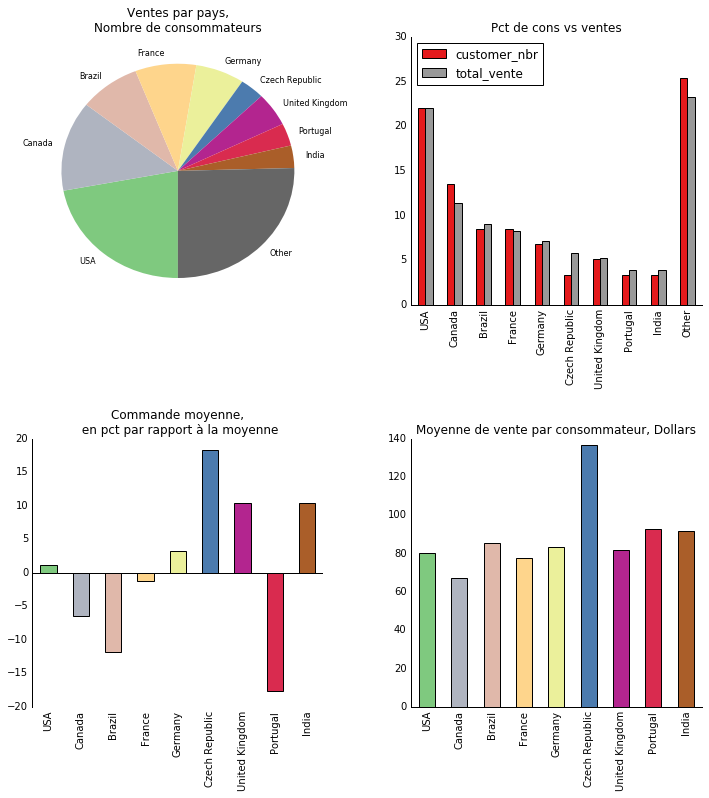

In [29]:
#Je créé une grille de 4 figures representant chacune une dimension de mes ventes
#figsize(largeur, hauteur) en pouces
fig = plt.figure(figsize=(12, 12))
#ajuste les contours des graphiques de la grille, ici espace entre les graphes en haut (height space)
# et sur les côtés (widht space) 
fig.subplots_adjust(hspace=.5, wspace=.3)

#On choisit les couleurs (4)
#cm=colormap biblio de matplotlib et accent est un colormap (jeu de couleur)
#pour i appartenant à une plage de nombre [ici 4 car la dimension de la 1ère ligne de 
#visu_donnees_vente=4]également répartis entre 0 et 1 => en gros on choisis 4 couleurs également 
#positionnées sur le camaieu de couleurs de Accent.
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, visu_donnees_vente.shape[0])]
#Je dessine chacune de mes figures

#1ere figure = Nombre de consommateurs (pie chart)
ax1 = fig.add_subplot(2,2,1)
#ax1.flatten() => je n'en ai pas besoin puisque je travaille les figures une à une, si j'avais 
#déclaré la grille(fig) et les axes globalement, le flatten permet de les considérer 1 à 1
nbr_conso = visu_donnees_vente["customer_nbr"].copy().rename('')
nbr_conso.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Ventes par pays,\nNombre de consommateurs',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0})

#2eme figure = total ventes par pays (graphiques de barres)
ax2 = fig.add_subplot(2,2,2)
cols = ["customer_nbr","total_vente"]
total_ventes = visu_donnees_vente[cols].copy()
total_ventes.index.name = ''
for c in cols:
    total_ventes[c] /= total_ventes[c].sum() / 100
total_ventes.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct de cons vs ventes"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#3eme figure (graphique de barres inversé)
ax3 = fig.add_subplot(2,2,3)
commande_moy_cons = visu_donnees_vente["commande_moyenne_par_pays"].copy()
commande_moy_cons.index.name = ''
difference_par_rapp_moy = commande_moy_cons * 100 / commande_moy_cons.mean() - 100
difference_par_rapp_moy.drop("Other", inplace=True)
difference_par_rapp_moy.plot.bar(
    ax=ax3,
    color=colors,
    title="Commande moyenne,\n en pct par rapport à la moyenne"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

#4eme figure graphique de bar
ax4 = fig.add_subplot(2,2,4)
vente_par_cons = visu_donnees_vente["moyenne_vente_par_cons"].copy()
vente_par_cons.index.name = ''
vente_par_cons.drop("Other",inplace=True)
vente_par_cons.plot.bar(
    ax=ax4,
    color=colors,
    title="Moyenne de vente par consommateur, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

### Les conclusions

Il y a des opportunités dans les pays ci-dessous :

* Czech Republic
* United Kingdom
* India

car malgré le moindre nombre de consommateurs, les ventes ne sont pas mal. Mais il faut être précautionneux car c'est ce même nombre restreint de consommateurs qui pourrait être un effet ponctuel et non une tendance générale.
Il est possible de procéder par petites touches de pub pour voir comment les gens réagissent.

## Catégoriser les factures en achats d'album ou pas 

In [8]:
#test=''''''
#tst=run_query(test)
#tst

In [7]:
q6 = '''
WITH 
   album_list_tracks AS
     (SELECT a.album_id,
             t.track_id
      FROM album a 
      INNER JOIN track t ON a.album_id=t.album_id),
      
   invoice_list_tracks AS
      (SELECT i.invoice_id,
              t.track_id,
              a.album_id
       FROM invoice i 
       INNER JOIN invoice_line il ON i.invoice_id=il.invoice_id
       INNER JOIN track t ON il.track_id=t.track_id
       LEFT JOIN album a ON a.album_id=t.album_id),
       
   add_column_album AS
      (SELECT i.invoice_id,
              CASE WHEN ((SELECT al.track_id 
                          FROM album_list_tracks al 
                          WHERE al.album_id=(SELECT MIN(il.album_id) FROM invoice_list_tracks il
                                             WHERE il.invoice_id=i.invoice_id GROUP BY il.invoice_id)
                          EXCEPT
                          SELECT il.track_id
                          FROM invoice_list_tracks il
                          WHERE il.invoice_id=i.invoice_id) IS NULL
                          AND
                         (SELECT il.track_id
                          FROM invoice_list_tracks il
                          WHERE il.invoice_id=i.invoice_id
                          EXCEPT
                          SELECT al.track_id 
                          FROM album_list_tracks al 
                          WHERE al.album_id=(SELECT MIN(il.album_id) FROM invoice_list_tracks il
                                             WHERE il.invoice_id=i.invoice_id GROUP BY il.invoice_id)) IS NULL) 
                   THEN 'yes'
                   ELSE 'no'
            END AS is_album_purchase
        FROM invoice i)

SELECT 
     ac.is_album_purchase,
     COUNT(ac.is_album_purchase) nbr_invoices_album,
     (CAST(COUNT(ac.is_album_purchase) as float)/(SELECT CAST(COUNT(*) as float) FROM add_column_album))*100 pct_invoice_album   
FROM add_column_album ac
GROUP BY ac.is_album_purchase;  
'''
ventes_album=run_query(q6)
ventes_album

,is_album_purchase,nbr_invoices_album,pct_invoice_album
0,no,500,81.433225
1,yes,114,18.566775


## Victoire!!! i understood how to manage it !!!!

Une des clés une fois qu'on a trouvé comment calculer les sous-ensembles à comparer (liste de tous les sons d'une facture + liste de tous les sons de l'album correspondant au premier album acheté sur la facture')', c'est d'utiliser l'id de facture de l'outer requête 